In [1]:
%%time
# !head -n 20 bluetooth_graph_analysis.py 
!awk 'FNR>=28 && FNR<=50' bluetooth_graph_analysis.py
%run bluetooth_graph_analysis.py
%matplotlib inline

from speclib import misc, plotting, loaders, graph  # noqa
PRINT = False
PRINT_PROGRESS = True


# @jit()
def compareDfUsers(baseuser, peers, df, simfnc):
    # Compute the similarity in the way they answered the questions
    dct = dict()
    for i in range(len(peers)):
        dct[(baseuser, peers[i])] = simfnc(df.loc[baseuser], df.loc[peers[i]])
    sim = pd.Series(dct).sort_values(ascending=False)
    return sim


dfa  = pd.read_msgpack('/lscr_paper/allan/allan_data/participants_graph_adjacency.msgpack')
mask = dfa.sum() != 0
dfa  = dfa.loc[mask, mask]  # drop zero-columns
if PRINT: print(dfa.head())  # noqa
qdf  = pd.read_json('/lscr_paper/allan/allan_data/RGender_.json')
f    = misc.QuestionFilterer(qdf)
ua   = loaders.Useralias()

Processing user u0001 (0/842)


/lscr_paper/allan/scripts/speclib/graph.py:562: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(ua, ub)/(np.sqrt(ua**2).sum() * np.sqrt(ub**2).sum())
/lscr_paper/allan/scripts/speclib/graph.py:590: RuntimeWarning: invalid value encountered in double_scalars
  return 2*np.dot(ua, ub) / (np.dot(ua, ua) + np.dot(ub, ub))


Processing user u0048 (40/842)
Processing user u0094 (80/842)
Processing user u0141 (120/842)
Processing user u0197 (160/842)
Processing user u0249 (200/842)
Processing user u0306 (240/842)
Processing user u0361 (280/842)
Processing user u0413 (320/842)
Processing user u0465 (360/842)
Processing user u0518 (400/842)
Processing user u0569 (440/842)
Processing user u0618 (480/842)
Processing user u0664 (520/842)
Processing user u0711 (560/842)
Processing user u0760 (600/842)
Processing user u0809 (640/842)
Processing user u0860 (680/842)
Processing user u0902 (720/842)
Processing user u0949 (760/842)
Processing user u1004 (800/842)
Processing user u1057 (840/842)
CPU times: user 23min 12s, sys: 3.18 s, total: 23min 15s
Wall time: 23min 13s


In [2]:
df = pd.DataFrame(qdct)
df = df.fillna(0)
df.columns.names = ['user', 'question', 'group', 'simfnc'] 

In [3]:
dfc = df.T.groupby(level=[1,2,3]).agg(['mean', 'std']).T
dfc = dfc.fillna(method='ffill') 

In [4]:
dfc.head() 

question   alcohol                                       bfi             \
group      control               homies              control              
simfnc      cosSim normDotSim    cosSim normDotSim    cosSim normDotSim   
0 mean    0.271423   0.825723  0.272670   0.827011  0.027350   0.931958   
  std     0.219226   0.203794  0.220724   0.197748  0.001947   0.041417   
1 mean    0.247814   0.759612  0.250561   0.767963  0.026818   0.920171   
  std     0.210405   0.204576  0.215049   0.203046  0.001742   0.038935   
2 mean    0.222608   0.702470  0.223810   0.712397  0.026532   0.914432   

question                      homophily               ...     selfesteem  \
group       homies              control               ...         homies   
simfnc      cosSim normDotSim    cosSim normDotSim    ...         cosSim   
0 mean    0.027420   0.929742  0.121462   0.929108    ...       0.156886   
  std     0.001951   0.038655  0.014887   0.055841    ...       0.029889   
1 mean    0.026929   0.921089  0.116428   0.910057    ...       0.153411   
  std     0.001798   0.039143  0.011571   0.056758    ...       0.029696   
2 mean    0.026629   0.915463  0.113929   0.897612    ...       0.151098   

question               stress                                  symptoms  \
group                 control               homies              control   
simfnc   normDotSim    cosSim normDotSim    cosSim normDotSim    cosSim   
0 mean     0.953751  0.150728   0.949638  0.150535   0.947839  0.314577   
  std      0.064660  0.035648   0.076942  0.035010   0.076032  0.221112   
1 mean     0.942141  0.145065   0.935225  0.145280   0.934895  0.263378   
  std      0.068857  0.032172   0.077017  0.032586   0.077162  0.175390   
2 mean     0.933022  0.141043   0.926535  0.141749   0.926303  0.229987   

question                                  
group                  homies             
simfnc   normDotSim    cosSim normDotSim  
0 mean     0.715341  0.306310   0.702210  
  std      0.232933  0.209432   0.228412  
1 mean     0.628243  0.267386   0.628466  
  std      0.207502  0.177587   0.206580  
2 mean     0.581621  0.232731   0.580363  

[5 rows x 48 columns]

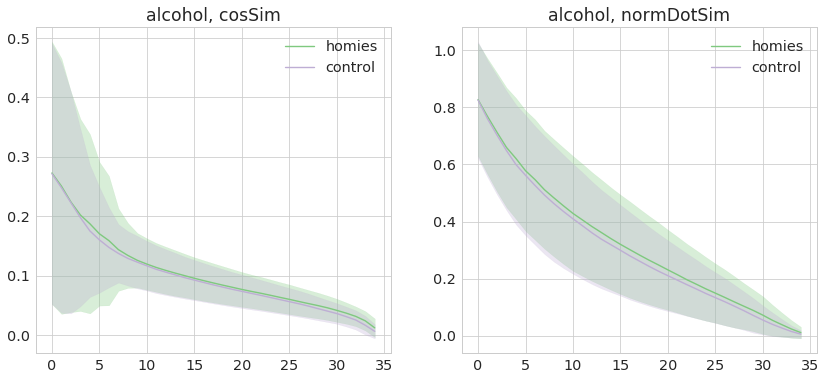

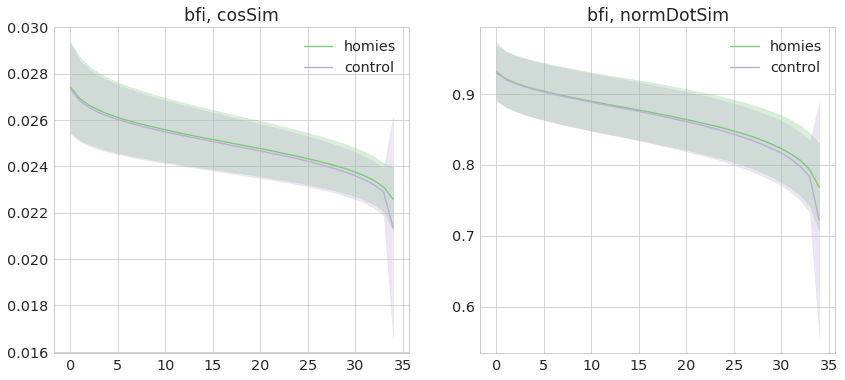

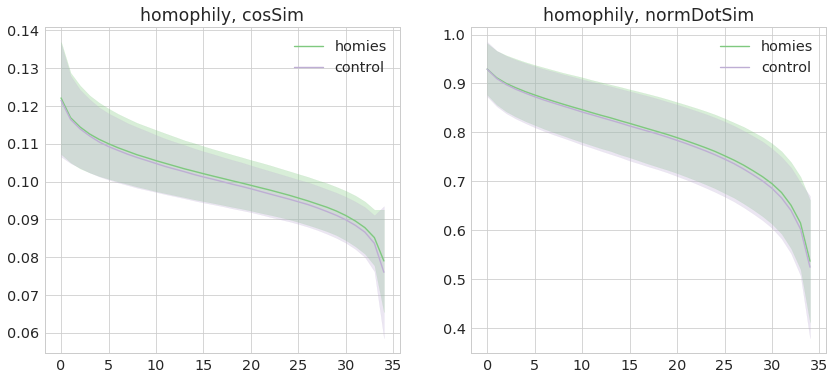

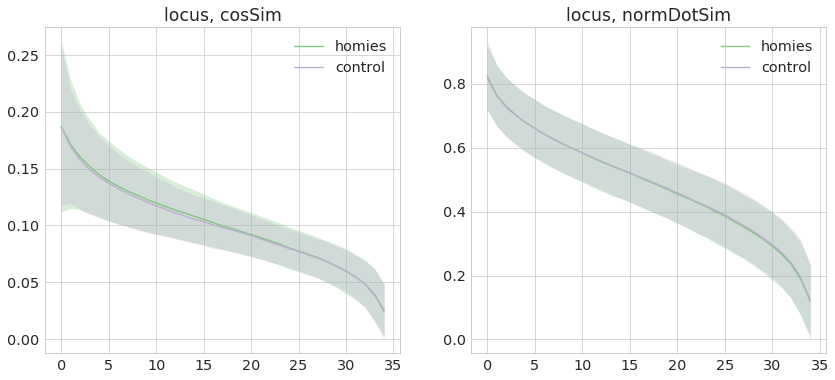

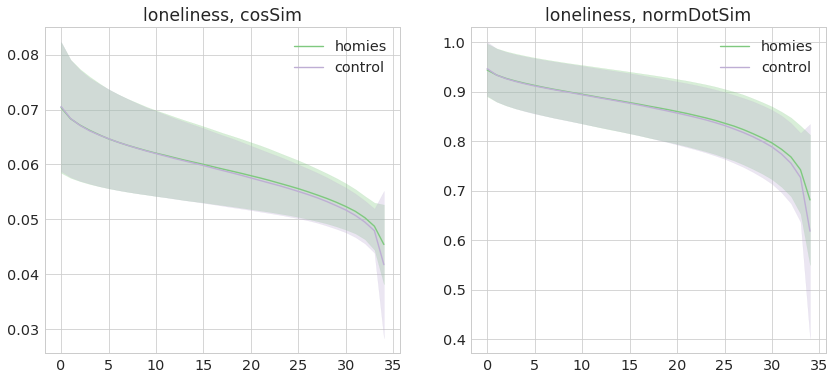

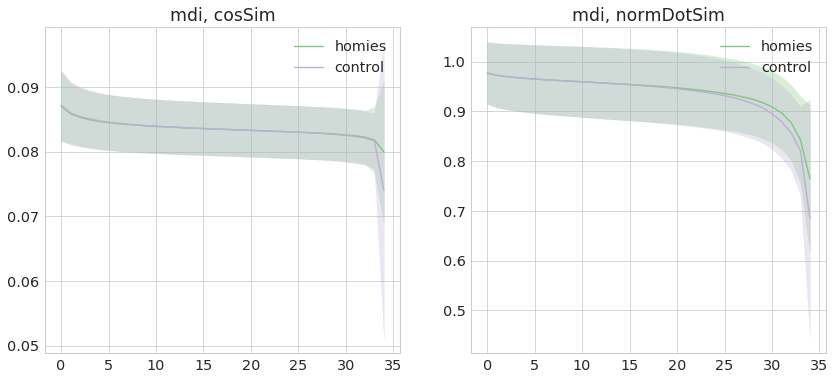

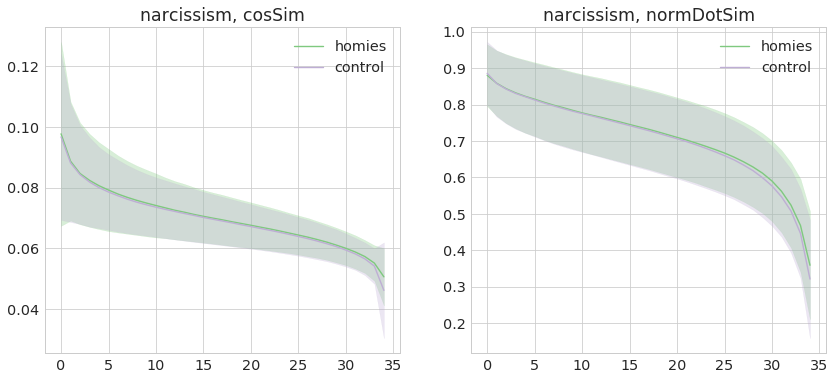

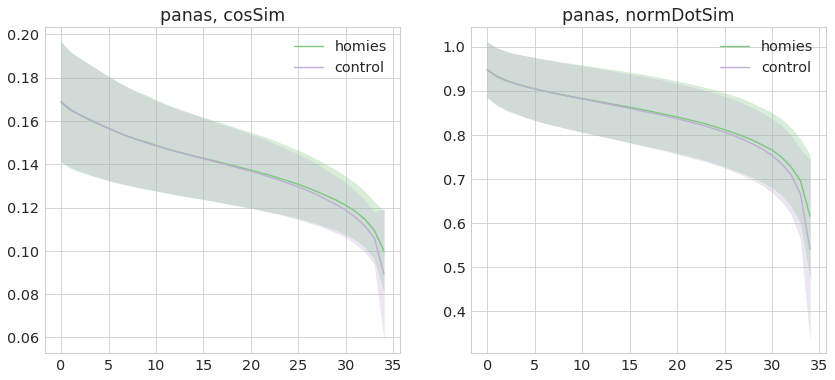

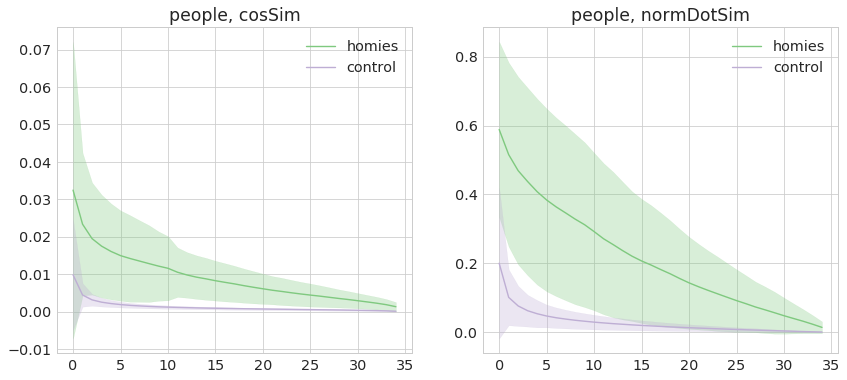

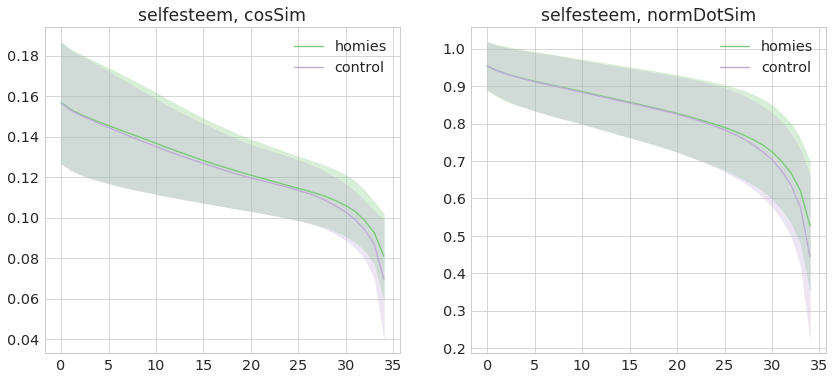

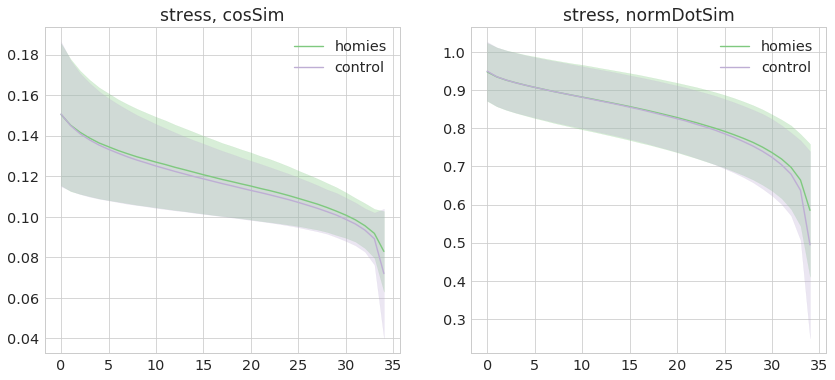

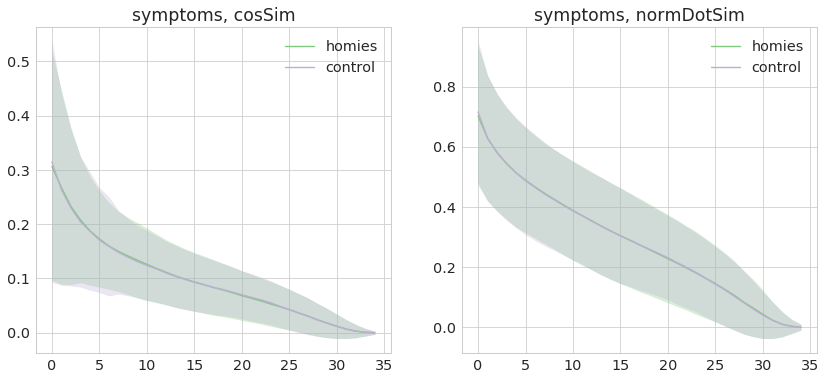

In [6]:
idx = pd.IndexSlice

for qst in dfc.columns.get_level_values('question').unique():
    fig, axi = plt.subplots(1, 2, figsize=(14, 6))
    for ax, fnc in zip(axi, dfc.columns.get_level_values('simfnc').unique()):
        dfc[qst]['homies'][fnc].loc[idx[:, 'mean']].plot(ax=ax, label='homies')
        upper_std = dfc[qst]['homies'][fnc].loc[idx[:, 'mean']] + dfc[qst]['homies'][fnc].loc[idx[:, 'std']]
        lower_std = dfc[qst]['homies'][fnc].loc[idx[:, 'mean']] - dfc[qst]['homies'][fnc].loc[idx[:, 'std']]
        ax.fill_between(dfc.index.get_level_values(0).unique(),
                        lower_std, upper_std, color=colorcycle[0], alpha=0.3)
        dfc[qst]['control'][fnc].loc[idx[:, 'mean']].plot(ax=ax, label='control')
        upper_std = dfc[qst]['control'][fnc].loc[idx[:, 'mean']] + dfc[qst]['control'][fnc].loc[idx[:, 'std']]
        lower_std = dfc[qst]['control'][fnc].loc[idx[:, 'mean']] - dfc[qst]['control'][fnc].loc[idx[:, 'std']]
        ax.fill_between(dfc.index.get_level_values(0).unique(),
                        lower_std, upper_std, color=colorcycle[1], alpha=0.3)
        ax.legend(loc='best')
        ax.set_title(qst + ', ' + fnc)
    del fig 



Text(0.5,1,'people_control')

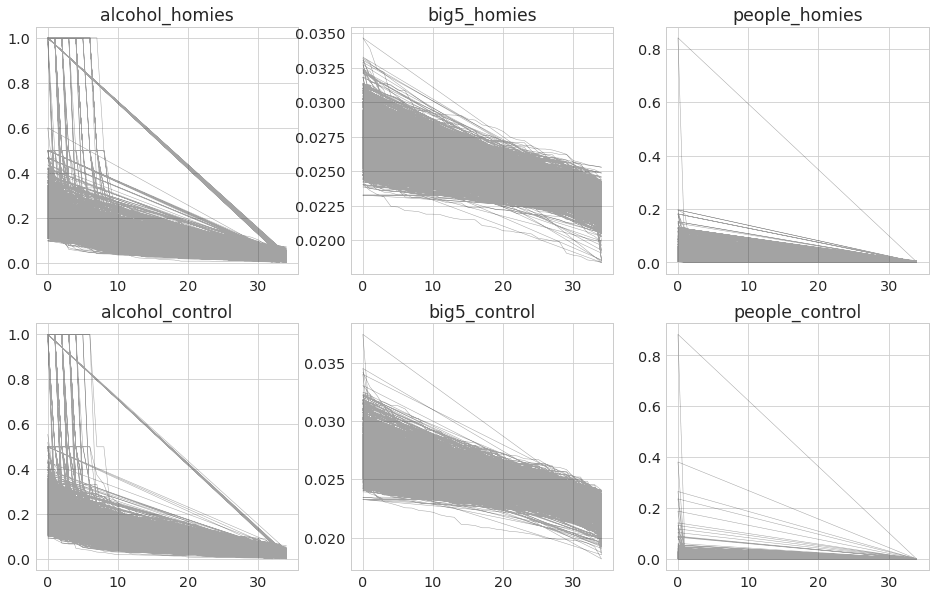

In [4]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(16, 10))
df_alcohol.alcohol_homies.plot(ax=ax11, alpha=0.4, lw=0.5, color='k')
ax11.set_title('alcohol_homies')
df_big5.big5_homies.plot(ax=ax12, alpha=0.4, lw=0.5, color='k')
ax12.set_title('big5_homies')
df_people.people_homies.plot(ax=ax13, alpha=0.4, lw=0.5, color='k')
ax13.set_title('people_homies')

df_alcohol.alcohol_control.plot(ax=ax21, alpha=0.4, lw=0.5, color='k')
ax21.set_title('alcohol_control')
df_big5.big5_control.plot(ax=ax22, alpha=0.4, lw=0.5, color='k')
ax22.set_title('big5_control')
df_people.people_control.plot(ax=ax23, alpha=0.4, lw=0.5, color='k')
ax23.set_title('people_control')
